## Setup

To access material for this workbook please execute the two notebook cells immediately below (e.g. use the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>). The first cell can be skipped if you are running this notebook locally and have already installed all the necessary packages. The second cell should print out "Your notebook is ready to go!"

In [ ]:
if 'pyodide_kernel' in str(get_ipython()):  # specify packages to install under JupyterLite
    raise RuntimeError("This workbook is not designed to run in JupyterLite. Please use a Colab or local install")
elif 'google.colab' in str(get_ipython()):  # specify package location for loading in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    %run /content/drive/MyDrive/GARG_workshop/Notebooks/add_module_path.py
else:  # install packages on your local machine (-q = "quiet": don't print out installation steps)
    !python -m pip install -q -r https://github.com/ebp-nor/GARG/raw/main/jlite/requirements.txt

In [1]:
# Load questions etc for this workbook
from IPython.display import SVG
import tskit
import ARG_workshop
workbook = ARG_workshop.Workbook2B()
display(workbook.setup)

✅ Your notebook is ready to go!


### Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

# Workbook 2-B: pairwise inference

The simplest ARG just consists of a pair of sample nodes, linked to a set of root nodes (sometimes called a "cherry" by phylogeneticists). There are no topological differences between the local trees, just a change in root height. Here's an example visualization:

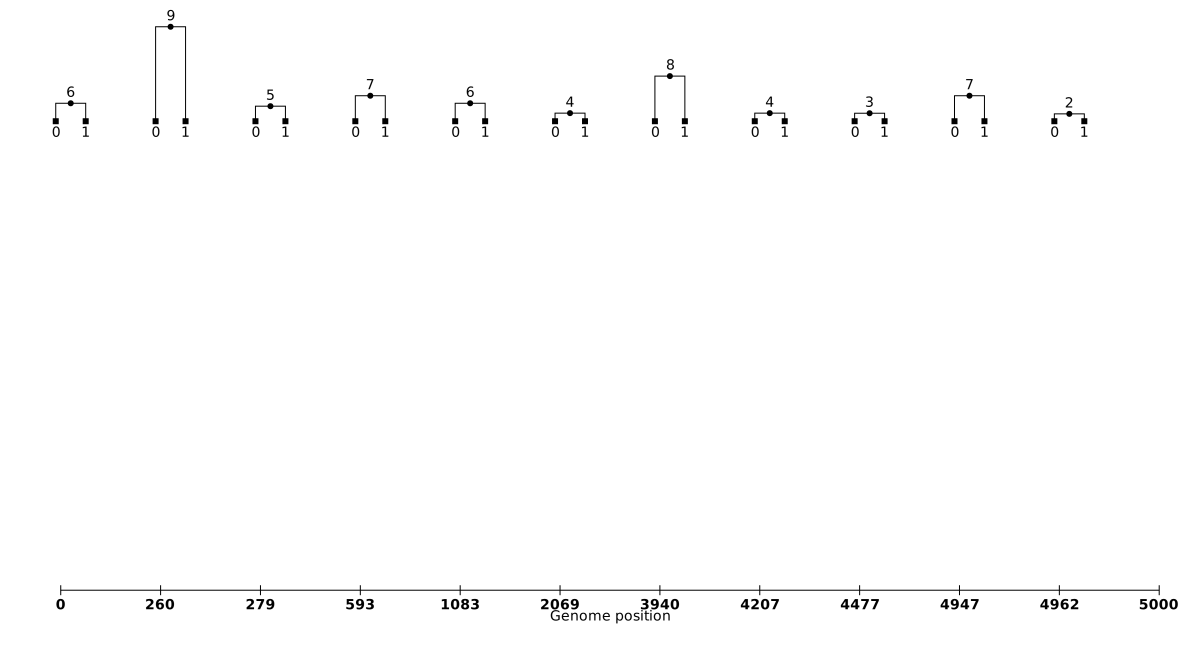

In [2]:
import msprime
import math
ts = msprime.sim_ancestry(1, population_size=1e5, sequence_length=5e3, recombination_rate=1e-8, random_seed=2)

# Snazzy 3D code taken from https://tskit.dev/tutorials/viz.html#d-effects
tree_width, height = 100, 200
y_step = 40  # Stagger between trees (i.e. 0 for all trees in a horizontal line)
skew = 0.3  # How skewed the trees are, in radians
n = ts.num_trees
width = tree_width * n + 20 + 20  # L & R margins
angle = math.atan(y_step/tree_width)
ax_mv = y_step, (n - 1) * y_step + math.tan(skew) * (tree_width * .9)
style = f".x-axis {{transform: translate({ax_mv[0]}px, {ax_mv[1]}px) skewY(-{angle}rad)}}"
for i in range(ts.num_trees):
    style += f".tree.t{i} > .plotbox {{transform:translateY({(n - i - 1) * y_step}px) skewY({skew}rad)}}"
canvas_size = (width + y_step, height + ts.num_trees*y_step + math.tan(skew)*tree_width)
ts.draw_svg(size=(width, height), x_scale="treewise", style=style, canvas_size=canvas_size)

You will see that the distances spanned by each tree can be quite variable (we have spaced them out evenly for visualization purposes, but e.g. the last tree only spans 38 bp out of this 5000bp genome.

As we previously saw, each coalescence point (i.e. MRCA, or root of the) can be surprisingly long ago. In a typical species, we might expect a pair of haploid genomes to contain tens of thousands of different roots on each reasonably sized chromosome. In a species such as humans, hundreds of thousands, or even millions of coalescent points are responsible for causing the variation between a pair of genomes. _Pairwise_ approaches, as long as they encompass the whole genome, are therefore a surprisingly informative source of information for inferring population history.

However, if we try to pair evey haploid genome with every other haploid genome, the scaling becomes quadratic, and therefore infeasible for large datasets. Fortunately, most organisms are *diploid*, and therefore it is quite reasonable to compare the two parental genomes in a single individual (after all, we know that they are likely to be from the same population, unless there has been very recent admixture). We can even do this for a large number of different individuals, for comparison.

This is the basic premise pioneered by Heng Li and Richard Durbin, in their classic [2011 paper](https://www.nature.com/articles/nature10231), associated with their [PSMC](https://github.com/lh3/psmc) software. Several elaborations on the basic method have been made, and there has been a burst of recent activity in the area.

In [3]:
# TODO: Question: what is the Sequentially Markovian Coalescent (SMC) approximation
# Execute code block with <shift>+Return to display question; type and press return, or click on the buttons to answer
workbook.question("smc")

<IPython.core.display.Javascript object>

## The idea behind PSMC

A major reason behind the success of PSMC-like methods is that there is no complex topology to infer. All that needs doing is to infer the (unknown) *time* of the MRCAs as we go along the genome. Compared to ARG inference methods that estimate topology (e.g. _tsinfer_) separately from node times (_tsdate_), it is basically equivalent to running only the second, dating step; as we'll see in the next workbook, that tends to be very fast.

If the SMC approximation holds, this allows a classic way to estimate hidden or unknown variables, using Hidden Markov Models (HMMs).



In [ ]:
# TODO: HMM question: what is the hidden state in the PSMC model


## Classic PSMC-like software

The original _PSMC_ software is still  and widely used, although it's now recommended to move to [MSMC2](https://github.com/stschiff/msmc2), e.g. see [this tutorial](https://evomics.org/learning/population-and-speciation-genomics/2020-population-and-speciation-genomics/demography-psmc-msmc/) by Richard Durbing, from whose group these two methods emerged.

We will encounter some of the bleeding edge methods like Phlash, cobraa, and Gamma-SMC in tomorrow's practical. However, for simple teaching purposes, this workbook will use a [python-only reimplementation](https://github.com/tulerpetontidae/psmc-python) of PSMC, which can take tree sequences as input. Thanks to Artem Lomakin for making this available: a copy of the code has been placed in the `pmsc_python` folder in the current directory.

We will follow the [psmc-python example notebook](https://github.com/tulerpetontidae/psmc-python/blob/main/example-tskit.ipynb) and download some data stored in _tskit_ format from the [Unified genealogy](https://www.science.org/doi/10.1126/science.abi8264). We will then re-infer MRCAs for individuals using PSMC.

In [ ]:
import urllib.request
import os
chrom = "17_q"  # Q arm of chr 17
file = f"hgdp_tgp_sgdp_chr{chrom}.dated.trees.tsz"
if not os.path.exists(file):
    with workbook.download(url) as t:
        urllib.request.urlretrieve(url, filename=file, reporthook=t.update_to)

In [ ]:
import tszip
import json

# Open and pick some selected genomes
ts = tszip.decompress(file).trim()  # remove the missing flanking regions
# Make a dict of 5 individuals from different populations, taken from the HGDP data
use_pops = {"Biaka", "Mbuti", "San", "Japanese", "Uygur", "French"}
all_pops = set()
individuals = {}
for i in ts.individuals():
    metadata = json.loads(i.metadata.decode())
    if metadata.get("sample", "").startswith("HGDP"):
        # This is an HGDP individual (could also try with SGDP or 1000genomes)
        pop = ts.population(ts.node(i.nodes[0]).population)
        pop_metadata = json.loads(pop.metadata.decode())
        name = pop_metadata["name"]
        all_pops.add(name)
        if name in use_pops:
            print(f"Using {metadata['sample']} from {pop_metadata}")
            individuals[name + "-" + pop_metadata["region"]] = i.id
            use_pops.remove(name)

print(f"Couldn't find {use_pops} in {all_pops}" if len(use_pops) else f"Individual IDs: {individuals}")


To get reasonable results, you would normally run PSMC on a large number of chromosomes, simultaneously.

In [ ]:
from psmc_python.model import PSMC
from psmc_python.plot import plot_history
from psmc_python.utils import process_ts
import numpy as np

# get an `x` object for input into psmc-python - this will have only one chromosome
# we could also combine chromosomes from different individuals
x = process_ts(ts, individual=individuals['Biaka-AFRICA'], progress=True)
print(f"Using {x.shape[1]} 100bp windows")

# initialise new instance and run EM
theta0 = np.sum(x) / (x.shape[0] * x.shape[1])
rho0 = theta0 / 5

psmc_model = PSMC(t_max=15, n_steps=64, pattern='1*4+25*2+1*4+1*6')
psmc_model.param_recalculate()

initial_params = [theta0, rho0, 15] + [1.] * (psmc_model.n_free_params - 3)
bounds = [(1e-4, 1e-1), (1e-5, 1e-1), (12, 20)] + [(0.1, 10)] * (psmc_model.n_free_params - 3)

We can now run the EM algorithm. This may take e.g. 10 minutes to run 

In [ ]:
loss_list, params_history = psmc_model.EM(initial_params, bounds, x=x, n_iter=10)
psmc_model.save_params("data/Biaka-AFRICA-HGDP.json")

The result is in scaled coalescence time. To convert to generations, we need to multiply by 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,6))
psmc = PSMC()
psmc.load_params("data/Biaka-AFRICA-HGDP.json")
plot_history(psmc_model, th=20, axs=ax, label="Biaka-AFRICA", color="red")

Since this is based on whole genome sequencing, and the According to Heng Li, the PSMC author, ["Not correcting for low coverage is the most common pitfall when using PSMC."(https://github.com/lh3/psmc)

main mistake that people make is not 

## Other useful HMMs

On the topic of HMMs, 
It's worth mentioning another now-classic HMM: the Li & Stephens HMM. This lies behind



In [ ]:
import tszip
ts = tszip.decompress("/Users/yan/Downloads/1kgp_all-chr20p-filterNton23-truncate-0-0-0-mm0-post-processed.trees.tsz")

In [ ]:
import tskit
tskit.__version__

In [ ]:
!pip install --upgrade git+https://github.com/tskit-dev/tskit#subdirectory=python